In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model,Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D,Input
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121

In [2]:
disease_types=['Parasitized','Uninfected']
data_dir = 'data'
train_dir = os.path.join(data_dir)

In [3]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])
        
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])
train.head()

,File,DiseaseID,Disease Type
0,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0,Parasitized
1,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0,Parasitized
2,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0,Parasitized
3,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0,Parasitized
4,Parasitized/C100P61ThinF_IMG_20150918_144104_c...,0,Parasitized


In [4]:
SEED = 42
train = train.sample(frac=1, random_state=SEED) 
train.index = np.arange(len(train)) # Reset indices
train.head()

,File,DiseaseID,Disease Type
0,Parasitized/C130P91ThinF_IMG_20151004_142951_c...,0,Parasitized
1,Parasitized/C188P149ThinF_IMG_20151203_134229_...,0,Parasitized
2,Uninfected/C173P134NThinF_IMG_20151130_125408_...,1,Uninfected
3,Parasitized/C68P29N_ThinF_IMG_20150819_134504_...,0,Parasitized
4,Parasitized/C99P60ThinF_IMG_20150918_142128_ce...,0,Parasitized


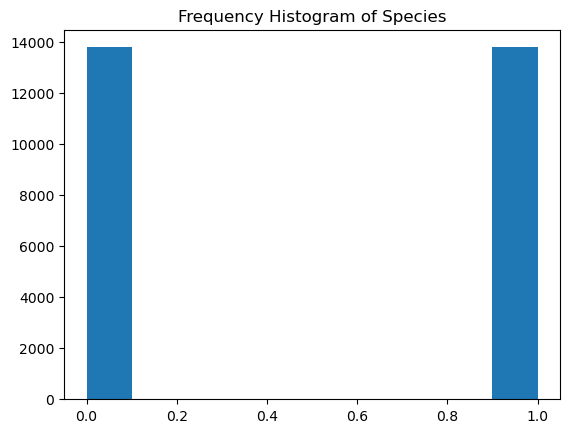

<Figure size 1200x1200 with 0 Axes>

In [5]:
plt.hist(train['DiseaseID'])
plt.title('Frequency Histogram of Species')
plt.figure(figsize=(12, 12))
plt.show()

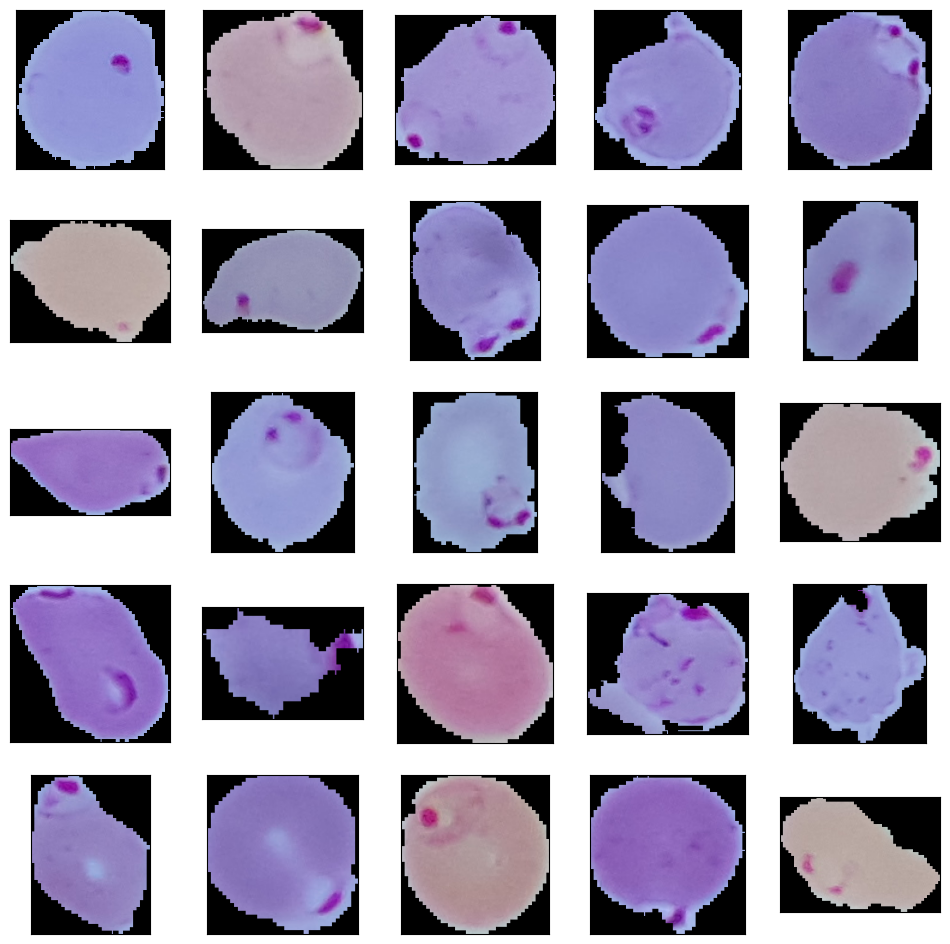

In [6]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Parasitized', 5, 5)

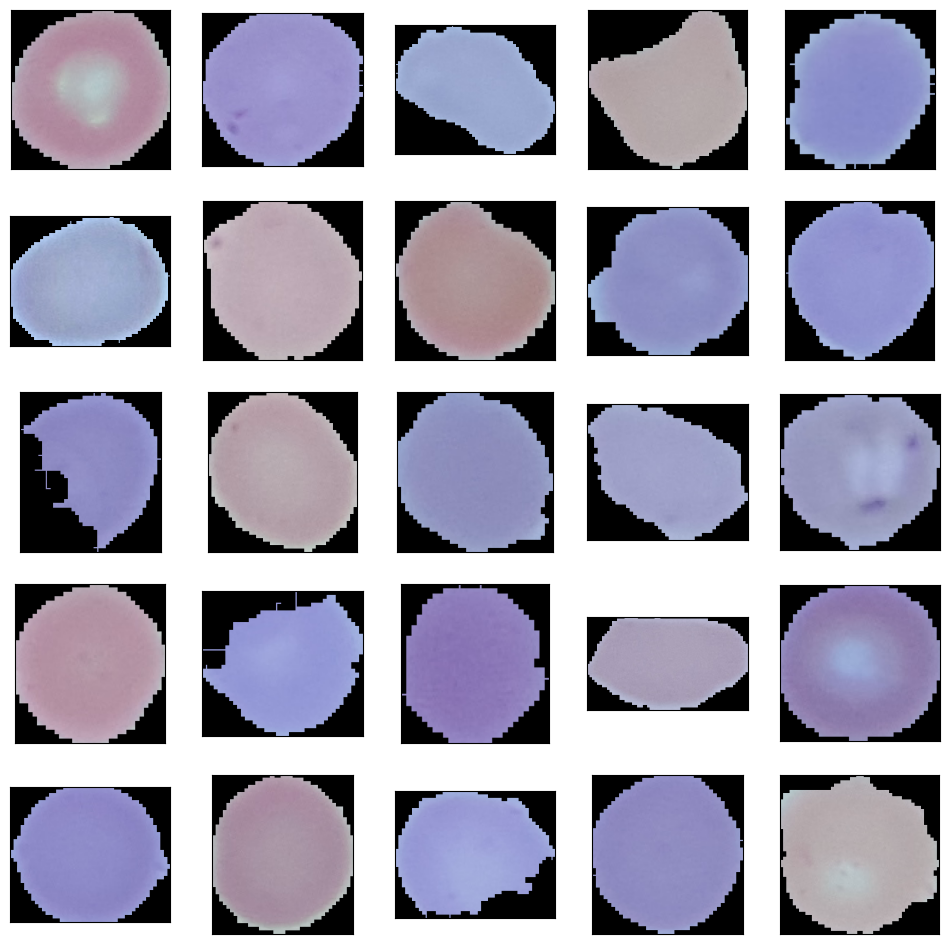

In [7]:
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values
    n = 0
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[n])
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
            ax[i, j].imshow(cv2.imread(image_path))
            n += 1
# Displays first n images of class from training set
plot_defects('Uninfected', 5, 5)

In [8]:

IMAGE_SIZE = 32
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading a color image is the default flag
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [9]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
# Normalize the data
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

27560it [00:38, 721.99it/s]


Train Shape: (27560, 32, 32, 3)


In [11]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [12]:
BATCH_SIZE = 32

# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

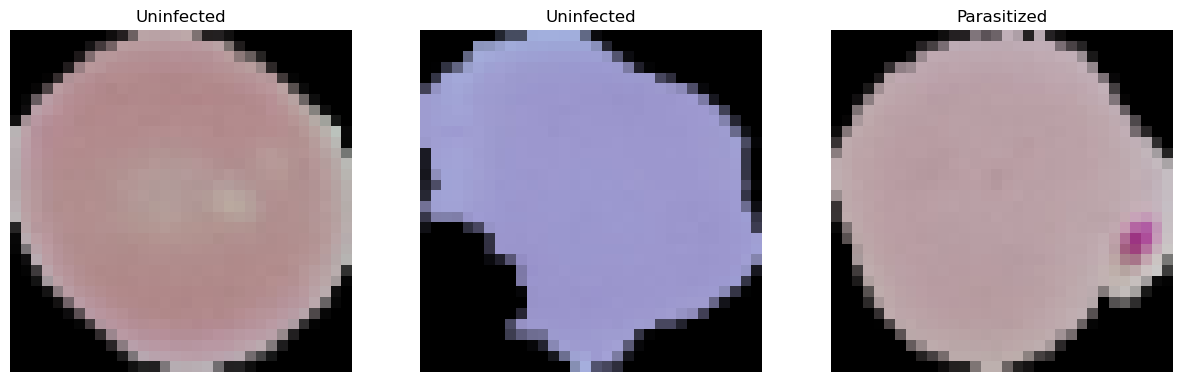

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 15))
for i in range(3):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(disease_types[np.argmax(Y_train[i])])

In [15]:
EPOCHS = 20
SIZE=32
N_ch=3

In [16]:
from keras.optimizers import Adam

In [17]:
def build_densenet():
    densenet = DenseNet121(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = densenet(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    
    optimizer = Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [18]:
# Implement early stopping
from keras.callbacks import EarlyStopping

In [19]:
model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('Malaria.h5', verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        vertical_flip=True)

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint,early_stopping],
               validation_data=(X_val, Y_val))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 3)         84        
                                                                 
 densenet121 (Functional)    (None, None, None, 1024   7037504   
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                             

C:\Users\addur\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


689/689 - 301s - loss: 0.6139 - accuracy: 0.7390 - val_loss: 0.4350 - val_accuracy: 0.8037 - lr: 0.0020 - 301s/epoch - 436ms/step
Epoch 2/20

Epoch 2: val_loss improved from 0.43499 to 0.41691, saving model to Malaria.h5
689/689 - 271s - loss: 0.3222 - accuracy: 0.8672 - val_loss: 0.4169 - val_accuracy: 0.7925 - lr: 0.0020 - 271s/epoch - 393ms/step
Epoch 3/20

Epoch 3: val_loss improved from 0.41691 to 0.15677, saving model to Malaria.h5
689/689 - 274s - loss: 0.2335 - accuracy: 0.9126 - val_loss: 0.1568 - val_accuracy: 0.9409 - lr: 0.0020 - 274s/epoch - 398ms/step
Epoch 4/20

Epoch 4: val_loss improved from 0.15677 to 0.13492, saving model to Malaria.h5
689/689 - 271s - loss: 0.2079 - accuracy: 0.9268 - val_loss: 0.1349 - val_accuracy: 0.9574 - lr: 0.0020 - 271s/epoch - 394ms/step
Epoch 5/20

Epoch 5: val_loss improved from 0.13492 to 0.11718, saving model to Malaria.h5
689/689 - 274s - loss: 0.1977 - accuracy: 0.9305 - val_loss: 0.1172 - val_accuracy: 0.9599 - lr: 0.0020 - 274s/epoch

In [20]:
#model = load_model('../output/kaggle/working/model.h5')
final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

173/173 [==============================] - 14s 81ms/step - loss: 0.1143 - accuracy: 0.9599
Final Loss: 0.11428967118263245, Final Accuracy: 0.9599056839942932


173/173 [==============================] - 15s 77ms/step


Text(0.5, 192.72222222222217, 'Predicted')

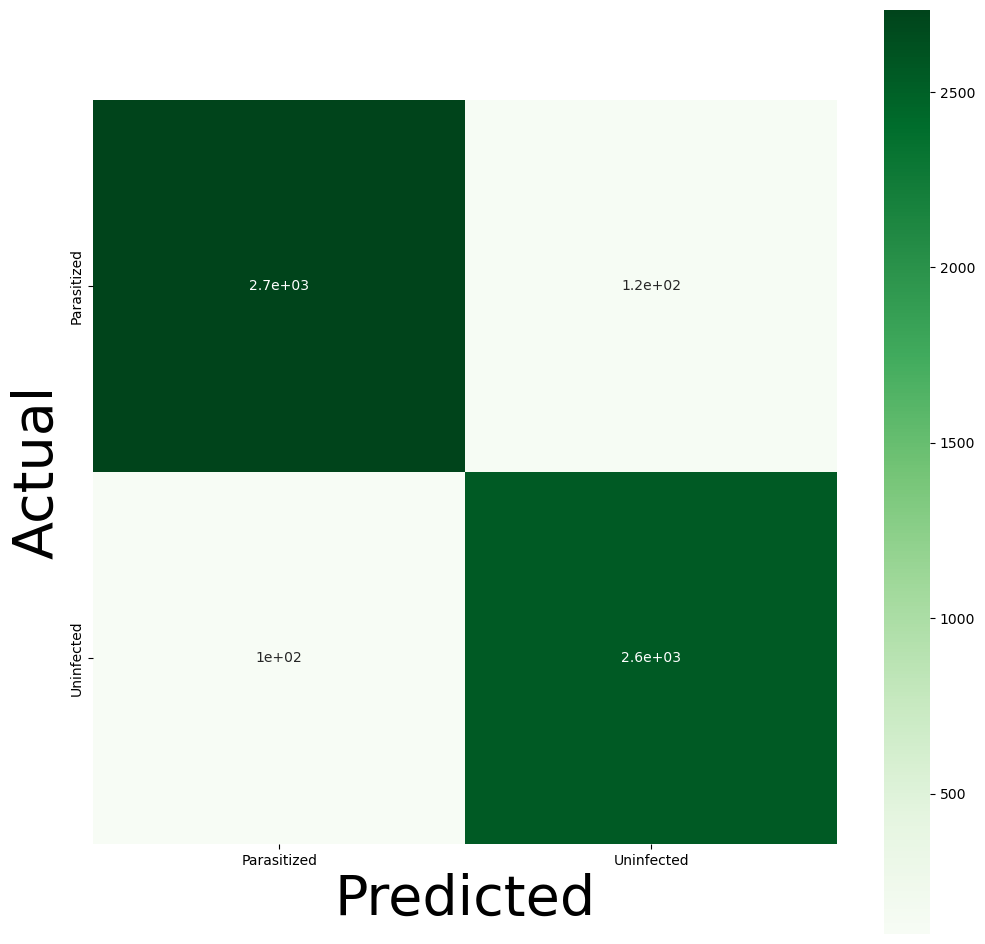

In [21]:
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

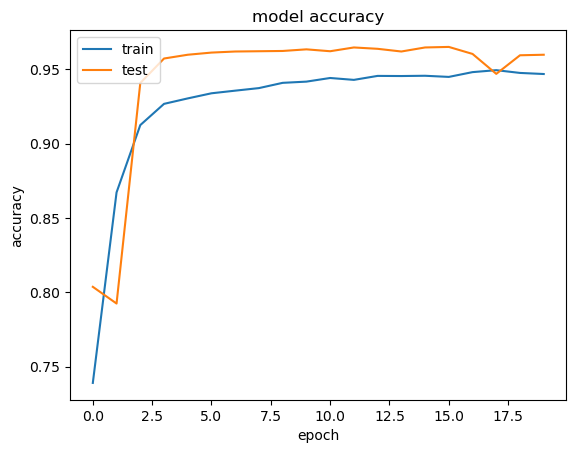

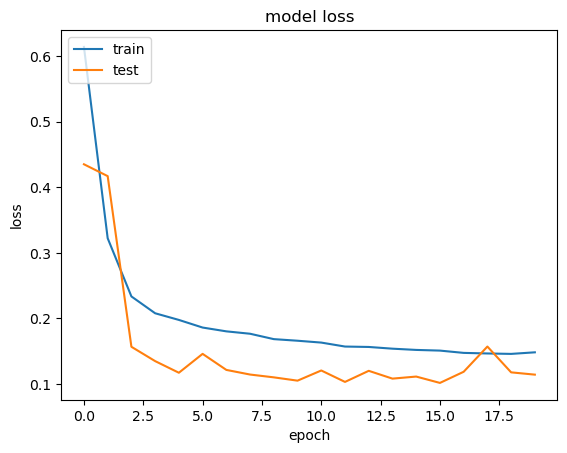

In [22]:

# accuracy plot 
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 2s 2s/step
[0.986509   0.01349096]


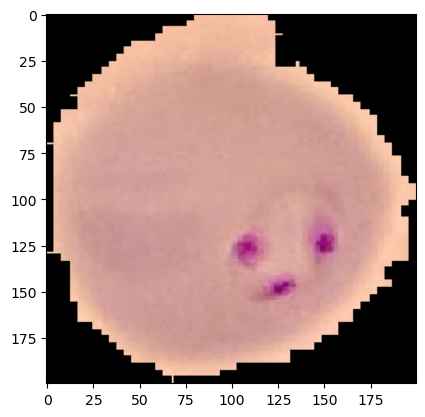

Prediction: Parasitized


In [23]:
from skimage import io
from keras.preprocessing import image
#path='imbalanced/Scratch/Scratch_400.jpg'
img = image.load_img('data/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png', grayscale=False, target_size=(64, 64))
show_img=image.load_img('data/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png', grayscale=False, target_size=(200, 200))
disease_class=['Parasitized','Uninfected']
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

custom = model.predict(x)
print(custom[0])

plt.imshow(show_img)
plt.show()

a=custom[0]
ind=np.argmax(a)
        
print('Prediction:',disease_class[ind])